# Testing PyTorch Dataset

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

In [2]:
# manual seed for reproducibility
torch.manual_seed(855413)
np.random.seed(9991)

In [3]:
from SineGratesDataset import SineGrates

In [4]:
transform = transforms.Compose(
    [transforms.PILToTensor(),
     transforms.ConvertImageDtype(torch.float)
     #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [5]:
trainset = SineGrates(cat_scheme='rb', length=256, transform=transform)
testset = trainset
#testset = SineGrates(cat_scheme='rb', length=1000, transform=transform)

In [6]:
label, image = next(iter(trainset))

In [7]:
image[0,100]

tensor([0.5020, 0.5020, 0.5020, 0.5020, 0.5020, 0.5020, 0.5020, 0.5020, 0.5020,
        0.5020, 0.5020, 0.5020, 0.5020, 0.5020, 0.5020, 0.5020, 0.5020, 0.5020,
        0.5020, 0.5020, 0.5020, 0.5020, 0.4941, 0.4471, 0.3490, 0.2510, 0.1843,
        0.1333, 0.0902, 0.0549, 0.0275, 0.0118, 0.0039, 0.0039, 0.0157, 0.0392,
        0.0706, 0.1098, 0.1569, 0.2118, 0.2706, 0.3333, 0.4039, 0.4706, 0.5412,
        0.6118, 0.6784, 0.7412, 0.8000, 0.8549, 0.8980, 0.9373, 0.9647, 0.9843,
        0.9961, 0.9961, 0.9882, 0.9686, 0.9412, 0.9020, 0.8588, 0.8039, 0.7490,
        0.6863, 0.6157, 0.5490, 0.4784, 0.4078, 0.3412, 0.2745, 0.2157, 0.1608,
        0.1137, 0.0745, 0.0392, 0.0196, 0.0039, 0.0039, 0.0078, 0.0235, 0.0510,
        0.0863, 0.1294, 0.1804, 0.2353, 0.2980, 0.3647, 0.4314, 0.5020, 0.5725,
        0.6392, 0.7059, 0.7686, 0.8235, 0.8745, 0.9176, 0.9490, 0.9765, 0.9922,
        0.9961, 0.9961, 0.9804, 0.9569, 0.9255, 0.8863, 0.8353, 0.7804, 0.7216,
        0.6549, 0.5882, 0.5176, 0.4471, 

In [8]:
type(image)

torch.Tensor

# Setting up Data Pipeline

In [9]:
batch_size = 4

In [10]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=12)

In [11]:
classes = ['Condition A', 'Condition B']

In [12]:
# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #plt.imshow(npimg)
    plt.show()

dataiter = iter(trainloader)
labels, images = dataiter.next()

In [13]:
images.shape

torch.Size([4, 1, 256, 256])

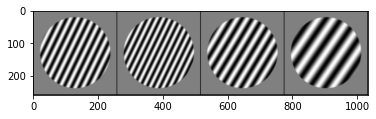

Condition B Condition B Condition B Condition A


In [14]:
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [15]:
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=12)
dataiter = iter(testloader)
labels, images = dataiter.next()

images.shape

torch.Size([4, 1, 256, 256])

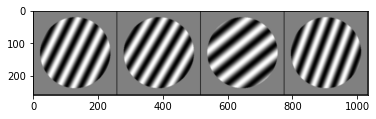

GroundTruth:  Condition A Condition A Condition A Condition A


In [16]:
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# Define a Neural Network

In [17]:
class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 2, dropout: float = 0.5) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 2, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(2, 2, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(2, 2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(2, 2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(2, 2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        #self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            #nn.Dropout(p=dropout),
            #nn.Linear(128 * 6 * 6, 16),
            
            #nn.Linear(2 * 7 * 7, 32),
            nn.Linear(2 * 7 * 7, num_classes)
            
            #nn.ReLU(inplace=True),
            #nn.Dropout(p=dropout),
            #nn.Linear(4096, 4096),
            #nn.ReLU(inplace=True),
            #nn.Linear(32, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        #print(x.shape)
        #x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [18]:
net = AlexNet()
net = net.cuda()

# Define Loss Function and Optimizer

In [19]:
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.5)
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [ ]:
for epoch in range(300):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        labels, images = data
        images = 2 * (images - 0.5002) # [0-1] to [-1,1]
        images = images.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    print(f"Epoch {epoch + 1}, loss: {running_loss:.3f}")
    running_loss = 0.0
    with torch.no_grad():
        correct = 0
        total = 0
        for i,data in enumerate(testloader,0):
            labels, images = data
            images = 2 * (images - 0.5002)
            images = images.cuda()
            labels = labels.cuda()
            outputs = net(images)
            softmax_labels = F.log_softmax(outputs, dim=1)
            preds_classes = torch.argmax(softmax_labels, axis=-1)
            correct += int(torch.sum(preds_classes.cpu() == labels.cpu()))
            total += batch_size
        print(f"\tTest Accuracy: {100*correct/total:.3f} %")


Epoch 1, loss: 80.387
	Test Accuracy: 93.164 %
Epoch 2, loss: 21.858
	Test Accuracy: 97.461 %
Epoch 3, loss: 8.896
	Test Accuracy: 99.023 %
Epoch 4, loss: 4.703
	Test Accuracy: 97.461 %
Epoch 5, loss: 6.453
	Test Accuracy: 99.609 %
Epoch 6, loss: 3.379
	Test Accuracy: 99.609 %
Epoch 7, loss: 4.418
	Test Accuracy: 99.805 %
Epoch 8, loss: 3.461
	Test Accuracy: 99.805 %
Epoch 9, loss: 1.922
	Test Accuracy: 99.609 %
Epoch 10, loss: 1.550
	Test Accuracy: 99.609 %
Epoch 11, loss: 1.045
	Test Accuracy: 99.805 %
Epoch 12, loss: 3.532
	Test Accuracy: 98.242 %
Epoch 13, loss: 2.710
	Test Accuracy: 99.023 %
Epoch 14, loss: 2.566
	Test Accuracy: 99.805 %
Epoch 15, loss: 0.782
	Test Accuracy: 99.805 %
Epoch 16, loss: 1.648
	Test Accuracy: 99.805 %
Epoch 17, loss: 0.814
	Test Accuracy: 100.000 %
Epoch 18, loss: 0.674
	Test Accuracy: 100.000 %
Epoch 19, loss: 0.582
	Test Accuracy: 98.438 %
Epoch 20, loss: 2.285
	Test Accuracy: 99.805 %
Epoch 21, loss: 0.703
	Test Accuracy: 99.805 %
Epoch 22, loss: 1.

No circular mask: Max accuracy 89.286% reached at Epoch 45
With circular mask: Max accuracy 89.286% reached at Epoch Epoch 51

Hilarious and shocking: Making the training set tiny (10) and overfittinng the training set returned the best model. Loss: 0.0, Test accuracy: 95.5%. (ii condition)

Same for 'rb' condition, but even higher accuracy: 97.0%

+ Adam lr=3e-5

This network (AlexNet-like) doesn't overfit the dataset beyond 80 training set, although maximum accuracy is reached at 160. (100%). The exact number depends on the numpy random seed (for dataset distribution).

I kept trying to weaken/lighten the neural network,
going so far as to replace Conv layers with AvgPool.
When it got stuck, I changed the seed.

Generally, lighter networks started tended to take longer to train.

ii
```
Epoch 1, loss: 85.18336582183838
Epoch 2, loss: 34.31419908697717
Epoch 3, loss: 20.531744883628562
Epoch 4, loss: 10.242627459112555
Epoch 5, loss: 8.574068777030334
Epoch 6, loss: 6.0638184630115575
Epoch 7, loss: 6.023264018360351
Epoch 8, loss: 5.1939516832790105
Epoch 9, loss: 5.4007573618218885
Epoch 10, loss: 5.164374641648465
Epoch 11, loss: 3.511080036558269
Epoch 12, loss: 4.276801145038917
Epoch 13, loss: 3.6609255538830894
Epoch 14, loss: 4.6994722907015785
Epoch 15, loss: 4.765986231519491
Epoch 16, loss: 4.714876491774248
Epoch 17, loss: 4.739646985006402
Epoch 18, loss: 3.8179756865556556
Epoch 19, loss: 3.849432604794856
Epoch 20, loss: 4.121982953985935
Epoch 21, loss: 3.3283890375539613
Epoch 22, loss: 5.158853088214528
Epoch 23, loss: 3.3509279994996177
Epoch 24, loss: 4.925103814290196
Epoch 25, loss: 3.597546736024924
Epoch 26, loss: 3.4156451058997845
Epoch 27, loss: 3.92656532269757
Epoch 28, loss: 3.454477835464786
Epoch 29, loss: 4.126161962380138
```

rb
```
Epoch 1, loss: 81.22609773278236
Epoch 2, loss: 14.698232750408351
Epoch 3, loss: 7.9504072612617165
Epoch 4, loss: 5.531502670957707
Epoch 5, loss: 2.597533548818319
Epoch 6, loss: 3.287875532914768
Epoch 7, loss: 1.6578662709071068
Epoch 8, loss: 2.9465451682626735
Epoch 9, loss: 3.038850345830724
Epoch 10, loss: 1.9624634058345691
Epoch 11, loss: 2.759255254357413
Epoch 12, loss: 2.156060866313055
Epoch 13, loss: 2.234694680584653
Epoch 14, loss: 2.082504246973258
Epoch 15, loss: 2.892491750237241
Epoch 16, loss: 2.1645498814541497
Epoch 17, loss: 2.2291575001727324
Epoch 18, loss: 1.7113196223872364
Epoch 19, loss: 1.599599110239069
Epoch 20, loss: 1.6463019263683236
Epoch 21, loss: 1.765304080741771
Epoch 22, loss: 2.0521400574434665
Epoch 23, loss: 2.256082821975724
Epoch 24, loss: 2.027793706598459
Epoch 25, loss: 1.510054058764581
Epoch 26, loss: 1.9244091983491671
Epoch 27, loss: 1.6030073140500463
Epoch 28, loss: 1.3176469673635438
Epoch 29, loss: 1.6648579663578857
```